# Final Models

## Group 13

Anusha Bhat, Aarav Dewangan, Mahima Masetty, Bruna Medeiros

# Data Loading and Cleaning

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, hamming
from sklearn.metrics import silhouette_samples
import random
from sklearn.preprocessing import MinMaxScaler
import gower
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

In [ ]:
# Load datasets
demographics_df = pd.read_csv("/Users/mahimamasetty/Desktop/DS for Algorithmic Marketing/The Complete Journey Dataset/hh_demographic.csv")
transactions_df = pd.read_csv("/Users/mahimamasetty/Desktop/DS for Algorithmic Marketing/The Complete Journey Dataset/transaction_data.csv")

In [ ]:
demographics_df.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [ ]:
transactions_df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [ ]:
# Merge datasets on customer_id
merged_df = pd.merge(transactions_df, demographics_df, on="household_key", how="inner")

In [ ]:
original_df = merged_df.copy()

In [ ]:
# Drop irrelevant columns
merged_df = merged_df.drop(columns=["household_key","BASKET_ID", "MARITAL_STATUS_CODE", "DAY", "WEEK_NO","PRODUCT_ID","STORE_ID","COUPON_MATCH_DISC"])

In [ ]:
merged_df.head()

,QUANTITY,SALES_VALUE,RETAIL_DISC,TRANS_TIME,COUPON_DISC,AGE_DESC,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,1,2.19,0.00,1520,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown
1,1,2.99,-0.40,1520,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown
2,1,3.09,0.00,1520,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown
3,1,2.50,-0.99,1520,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown
4,1,0.60,-0.79,1520,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427303 entries, 0 to 1427302
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   QUANTITY             1427303 non-null  int64  
 1   SALES_VALUE          1427303 non-null  float64
 2   RETAIL_DISC          1427303 non-null  float64
 3   TRANS_TIME           1427303 non-null  int64  
 4   COUPON_DISC          1427303 non-null  float64
 5   AGE_DESC             1427303 non-null  object 
 6   INCOME_DESC          1427303 non-null  object 
 7   HOMEOWNER_DESC       1427303 non-null  object 
 8   HH_COMP_DESC         1427303 non-null  object 
 9   HOUSEHOLD_SIZE_DESC  1427303 non-null  object 
 10  KID_CATEGORY_DESC    1427303 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 119.8+ MB


In [ ]:
# Change data type of time to string
merged_df["TRANS_TIME"] = merged_df["TRANS_TIME"].astype(str)
# Extract hour from HHMM format
merged_df["HOUR"] = merged_df["TRANS_TIME"].str[:2].astype(int)

# Define function to bucket times
def time_bucket(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"
merged_df["TRANS_TIME_OF_DAY"] = merged_df["HOUR"].apply(time_bucket)

# Drop the original time column
merged_df = merged_df.drop(columns=["TRANS_TIME", "HOUR"])

In [ ]:
merged_df.head()

,QUANTITY,SALES_VALUE,RETAIL_DISC,COUPON_DISC,AGE_DESC,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,TRANS_TIME_OF_DAY
0,1,2.19,0.00,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon
1,1,2.99,-0.40,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon
2,1,3.09,0.00,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon
3,1,2.50,-0.99,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon
4,1,0.60,-0.79,0.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon


In [ ]:
# Identify categorical columns
categorical_columns = merged_df.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = merged_df.select_dtypes(include=["int64","float64"]).columns.tolist()

# Create a dictionary to store encoders
label_encoders = {}

# Encode categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le  # Store encoder for future decoding

In [ ]:
scaler = MinMaxScaler()
merged_df[numerical_columns] = scaler.fit_transform(merged_df[numerical_columns])

In [ ]:
print(merged_df.isnull().sum())  # Check for NaNs

QUANTITY               0
SALES_VALUE            0
RETAIL_DISC            0
COUPON_DISC            0
AGE_DESC               0
INCOME_DESC            0
HOMEOWNER_DESC         0
HH_COMP_DESC           0
HOUSEHOLD_SIZE_DESC    0
KID_CATEGORY_DESC      0
TRANS_TIME_OF_DAY      0
dtype: int64


In [ ]:
merged_df.isna().sum()

QUANTITY               0
SALES_VALUE            0
RETAIL_DISC            0
COUPON_DISC            0
AGE_DESC               0
INCOME_DESC            0
HOMEOWNER_DESC         0
HH_COMP_DESC           0
HOUSEHOLD_SIZE_DESC    0
KID_CATEGORY_DESC      0
TRANS_TIME_OF_DAY      0
dtype: int64

# K-Prototypes Clustering

In [ ]:
# Sample 200k rows for faster computation, more than 10% of the full dataset
sample_size = 200_000
sampled_df = merged_df.sample(n=sample_size, random_state=42)
data_matrix = sampled_df.to_numpy()

# Get categorical column indices
categorical_indices = [merged_df.columns.get_loc(col) for col in categorical_columns]

# Compute cost for different k values
costs = []
k_values = range(2, 8)

In [ ]:
for k in k_values:
    print(f"Running K-Prototypes for k={k}...")

    try:
        # Fit K-Prototypes model
        kproto = KPrototypes(n_clusters=k, init="Random", n_init=3, verbose=0)
        clusters = kproto.fit_predict(data_matrix, categorical=categorical_indices)

        # Compute cost for elbow method
        print(f"Completed K-Prototypes for k={k}, Cost: {kproto.cost_}")
        costs.append(kproto.cost_)

    except Exception as e:
        print(f"Error at k={k}: {e}")
        break  # Stop execution if an error occurs

Running K-Prototypes for k=2...
Completed K-Prototypes for k=2, Cost: 2748.713425360922
Running K-Prototypes for k=3...
Completed K-Prototypes for k=3, Cost: 2510.833851428229
Running K-Prototypes for k=4...
Completed K-Prototypes for k=4, Cost: 2206.3882125950026
Running K-Prototypes for k=5...
Completed K-Prototypes for k=5, Cost: 2128.6841704462204
Running K-Prototypes for k=6...
Completed K-Prototypes for k=6, Cost: 2027.3063800819505
Running K-Prototypes for k=7...
Completed K-Prototypes for k=7, Cost: 1953.2319429081106


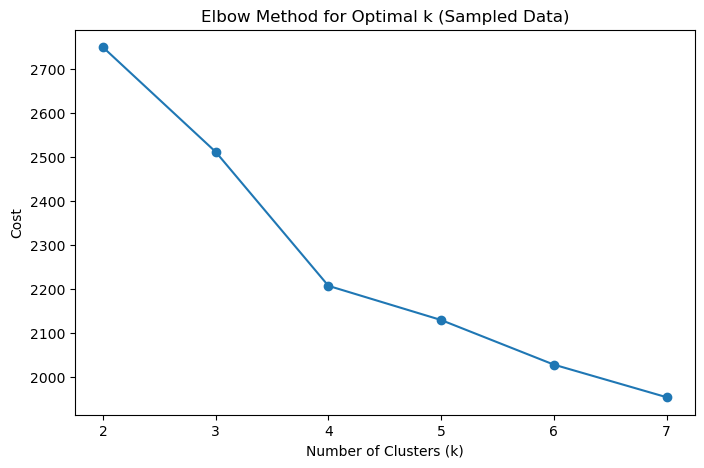

In [ ]:
# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, costs, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Cost")
plt.title("Elbow Method for Optimal k (Sampled Data)")
plt.show()

In [ ]:
optimal_k = 4

In [ ]:
full_data_matrix = merged_df.to_numpy()

kproto = KPrototypes(n_clusters=optimal_k, init="Random", n_init=3, verbose=1)
clusters = kproto.fit_predict(full_data_matrix, categorical=categorical_indices)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 262003, ncost: 16069.508591642589
Run: 1, iteration: 2/100, moves: 24844, ncost: 16069.42481362702
Run: 1, iteration: 3/100, moves: 8680, ncost: 16069.419781753943
Run: 1, iteration: 4/100, moves: 4042, ncost: 16069.418710668639
Run: 1, iteration: 5/100, moves: 3894, ncost: 16069.417095475686
Run: 1, iteration: 6/100, moves: 2546, ncost: 16069.416514900844
Run: 1, iteration: 7/100, moves: 191, ncost: 16069.41651225875
Run: 1, iteration: 8/100, moves: 14, ncost: 16069.416512063497
Run: 1, iteration: 9/100, moves: 1, ncost: 16069.416512058118
Run: 1, iteration: 10/100, moves: 0, ncost: 16069.416512058118
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 389729, ncost: 16942.781798844073
Run: 2, iteration: 2/100, moves: 77881, ncost: 16942.76910713377
Run: 2, iteration: 3/100, moves: 1113, ncost: 16942.769058686787


In [ ]:
merged_df["CLUSTER"] = clusters

In [ ]:
merged_df.head()

,QUANTITY,SALES_VALUE,RETAIL_DISC,COUPON_DISC,AGE_DESC,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,TRANS_TIME_OF_DAY,CLUSTER
0,0.000011,0.002607,0.993961,1.0,5,0,0,3,0,3,0,0
1,0.000011,0.003560,0.990903,1.0,5,0,0,3,0,3,0,0
2,0.000011,0.003679,0.993961,1.0,5,0,0,3,0,3,0,0
3,0.000011,0.002976,0.986392,1.0,5,0,0,3,0,3,0,0
4,0.000011,0.000714,0.987921,1.0,5,0,0,3,0,3,0,0


In [ ]:
# Decode categorical columns back to original values
for col in categorical_columns:
    le = label_encoders[col]  # Retrieve the stored label encoder
    merged_df[col] = le.inverse_transform(merged_df[col])  # Convert back to original values

In [ ]:
merged_df.head()

,QUANTITY,SALES_VALUE,RETAIL_DISC,COUPON_DISC,AGE_DESC,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,TRANS_TIME_OF_DAY,CLUSTER
0,0.000011,0.002607,0.993961,1.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon,0
1,0.000011,0.003560,0.990903,1.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon,0
2,0.000011,0.003679,0.993961,1.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon,0
3,0.000011,0.002976,0.986392,1.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon,0
4,0.000011,0.000714,0.987921,1.0,65+,100-124K,Homeowner,Single Female,1,None/Unknown,Afternoon,0


In [ ]:
# Cluster size distribution
print("Cluster Size Distribution:\n", merged_df['CLUSTER'].value_counts(), "\n")

Cluster Size Distribution:
 CLUSTER
3    540730
0    401500
1    251006
2    234067
Name: count, dtype: int64 



In [ ]:
merged_df = original_df.merge(merged_df[["CLUSTER"]], left_index=True, right_index=True)

In [ ]:
merged_df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,CLUSTER
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0


In [ ]:
# Change time for the dataset after merging with original dataset
merged_df["TRANS_TIME"] = merged_df["TRANS_TIME"].astype(str)
# Extract hour from HHMM format
merged_df["HOUR"] = merged_df["TRANS_TIME"].str[:2].astype(int)

# Define function to bucket times
def time_bucket(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"
merged_df["TRANS_TIME_OF_DAY"] = merged_df["HOUR"].apply(time_bucket)

# Drop the original time column
merged_df = merged_df.drop(columns=["TRANS_TIME", "HOUR"])

In [ ]:
# Summary statistics for numerical features
print("\nNumerical Feature Summary by Cluster:")
print(merged_df.groupby('CLUSTER')[numerical_columns].agg(['mean', 'std', 'median']))

# Category distribution for each cluster
print("\nCategorical Feature Distribution by Cluster:")
for col in categorical_columns:
    print(f"\nFeature: {col}")
    print(merged_df.groupby('CLUSTER')[col].value_counts(normalize=True))  # Relative frequencies
    print("-" * 50)


Numerical Feature Summary by Cluster:
           QUANTITY                     SALES_VALUE                   \
               mean          std median        mean       std median   
CLUSTER                                                                
0         76.592189   931.589879    1.0    2.853522  3.468988   2.00   
1        119.837259  1313.766046    1.0    3.185324  4.319014   2.14   
2         90.362452  1153.073909    1.0    3.071175  4.258126   2.18   
3        151.563046  1454.178619    1.0    3.391029  4.706004   2.29   

        RETAIL_DISC                  COUPON_DISC                   
               mean       std median        mean       std median  
CLUSTER                                                            
0         -0.450402  1.065357   0.00   -0.013831  0.192970    0.0  
1         -0.670917  1.345217  -0.22   -0.024258  0.277644    0.0  
2         -0.391622  1.051962   0.00   -0.022290  0.226921    0.0  
3         -0.596221  1.331449  -0.09   -0.020143

## Cluster Description

#### **Cluster 0: Single Low-Spending Shoppers**  
##### **Demographic Characteristics:**  
- **Age Group:** Majority in **45-54 (37.1%)**, followed by **35-44 (23.4%)** and **25-34 (17.7%)**.  
- **Income:** Primarily **$35K-$49K (27.7%)** and **$50K-$74K (18.5%)**, with **24.1% earning under $25K**.  
- **Marital Status:** High proportion of **single females (48.9%)** and **single males (26.3%)**.  
- **Household Size:** Predominantly **1-person households (85.9%)**.  
- **Children:** Almost exclusively **without children (95.1%)**.  
- **Homeownership:** Majority are **renters or have unknown status (72.7%)**.  

##### **Shopping Behavior:**  
- **Purchase Volume:** Lowest among clusters (mean quantity: 76.6).  
- **Spending Power:** Low (mean sales value: $2.85).  

- **Discount Reliance:** Moderate (mean retail discount: -$0.45).  

- **Shopping Time:** Shops throughout the day, mostly in the **afternoon (40.9%)** and **evening (33.6%)**.  

---

#### **Cluster 1: Young Families with Growing Needs**  
##### **Demographic Characteristics:**  
- **Age Group:** Dominated by **35-44 (46.8%)** and **25-34 (22.0%)**.  
- **Income:** Many earn **$75K-$149K (40.5%)**.  
- **Homeownership:** Majority are **homeowners (73.6%)**.  
- **Household Type:** Almost **80% are 2 adults with kids**.  
- **Household Size:** **74.4% have 3 members, 16.2% have 4 members**.  
- **Children:** **72.8% have at least 1 child**.  

##### **Shopping Behavior:**  
- **Purchase Volume:** Higher than average (mean quantity: 119.8).  
- **Spending Power:** Moderate (mean sales value: $3.19).  

- **Discount Orientation:** More discount-oriented, receiving higher retail discounts (-$0.67)

and coupon discounts (-$0.024)

- **Shopping Time:** Prefers afternoon shopping (52.1%), least likely to shop at night.  

---

#### **Cluster 2: Large Households & Price-Conscious Buyers**  
##### **Demographic Characteristics:**  
- **Age Group:** Majority in **45-54 (41.8%)** and **35-44 (27.4%)**.  
- **Income:** Higher-income mix, with **58.6% earning $50K-$149K**.  
- **Homeownership:** Majority are **homeowners (83.3%)**.  
- **Household Type:** **72.6% are 2 adults with kids, 14.9% are 1 adult with kids**.  
- **Household Size:** **53.6% have 5+ members, 26.1% have 4 members**.  
- **Children:** Very high proportion of families with **3+ children (55.8%)**.  

##### **Shopping Behavior:**  
- **Purchase Volume:** Higher than average (mean quantity: 90.4).  
- **Spending Power:** Moderate (mean sales value: $3.07).

- **Discount Orientation:** Least reliant on discounts (mean retail discount: -$0.39).  
- **Shopping Time:** Prefers evening shopping (51.1%), lower afternoon shopping activity.  

---

#### **Cluster 3: Wealthy Empty Nesters & Senior Shoppers**  
##### **Demographic Characteristics:**  
- **Age Group:** Majority in **45-54 (42.4%)** and **35-44 (20.5%)**, with **higher presence of 65+ (11.2%)**.  
- **Income:** Wealthier households, with **44.9% earning $75K-$174K**.  
- **Homeownership:** Highest proportion of **homeowners (85.4%)**.  
- **Household Type:** Mostly **empty nesters (79.2% are 2 adults, no kids)**.  
- **Household Size:** Predominantly **2-person (89.8%)**.  
- **Children:** Very few families with children (98.1% have none).  

##### **Shopping Behavior:**  
- **Purchase Volume:** Highest among all clusters (mean quantity: 151.6).  
- **Spending Power:** Highest (mean sales value: $3.39).

- **Discount Orientation:** Moderately discount-driven (mean retail discount: -$0.60).
- **Shopping Time:** Balanced distribution across afternoon (45.5%) and evening (30.4%).

In [ ]:
# Save clustered datasets
merged_df.to_csv('df_clustered_final.csv', index=False)

# Market Basket Analysis


In [ ]:
# load in clustered df and product df
df = pd.read_csv("df_clustered_final.csv")
prod_df = pd.read_csv("product.csv")

In [ ]:
prod_df.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [ ]:
# Want to merge dfs to have sub_commodity_desc for analysis
merged_df = pd.merge(df[["household_key", "BASKET_ID", "PRODUCT_ID", "QUANTITY", "CLUSTER"]],
                     prod_df[['PRODUCT_ID', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC']],
                     on='PRODUCT_ID', how='inner')

In [ ]:
merged_df.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,CLUSTER,COMMODITY_DESC,SUB_COMMODITY_DESC
0,1364,26984896261,842930,1,0,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS
1,1364,26984896261,897044,1,0,CRACKERS/MISC BKD FD,SNACK CRACKERS
2,1364,26984896261,920955,1,0,BEEF,GRND/PATTY - ROUND
3,1364,26984896261,937406,1,0,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW
4,1364,26984896261,981760,1,0,EGGS,EGGS - X-LARGE


In [ ]:
# Seperate by clusters
cluster_0 = merged_df[merged_df["CLUSTER"] == 0]
cluster_1 = merged_df[merged_df["CLUSTER"] == 1]
cluster_2 = merged_df[merged_df["CLUSTER"] == 2]
cluster_3 = merged_df[merged_df["CLUSTER"] == 3]

## Market Basket Analysis: Cluster 0

In [ ]:
# Clean data
cluster_0['SUB_COMMODITY_DESC'] = cluster_0['SUB_COMMODITY_DESC'].str.strip()
cluster_0 = cluster_0[cluster_0['SUB_COMMODITY_DESC'] != 'NO SUBCOMMODITY DESCRIPTION']
df.dropna(axis=0, subset=['BASKET_ID'], inplace=True)
df['BASKET_ID'] = df['BASKET_ID'].astype('str')

<ipython-input-10-6b5b3bd92732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0['SUB_COMMODITY_DESC'] = cluster_0['SUB_COMMODITY_DESC'].str.strip()


In [ ]:
# Get baskets
basket = (cluster_0
          .groupby(['BASKET_ID', 'SUB_COMMODITY_DESC'])['QUANTITY']
          .sum().unstack().reset_index().fillna(0)
          .set_index('BASKET_ID'))

basket.head()

SUB_COMMODITY_DESC,,*GOURMET/UPSCALE,*MISC. LOBBY ITEMS,*SPRING/SUMMER MISC,ABRASIVES,ACCESSORIES,ACNE MEDICATIONS,ADDITIVES/FLUIDS,ADHESIVES/CAULK,ADULT ANALGESICS,...,WOMEN S GENERAL-MAGAZINE,WOMENS HAIR SPRAYS,WOMENS /GIRLS SOCKS,WOMENS/GIRLS HOSIERY,WRITING INSTRUMENTS,YEAST: DRY,YELLOW SUMMER SQUASH,YOGURT,YOGURT MULTI-PACKS,YOGURT NOT MULTI-PACKS
BASKET_ID,,,,,,,,,,,,,,,,,,,,,
26984896261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26985025264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26985205886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26996870743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27008850617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Top 25 Frequent item sets
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

<ipython-input-12-eb4a4790619f>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)


In [ ]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
final_frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) >= 2)]

In [ ]:
# displaying max column width to view all the itemsets
pd.set_option('display.max_colwidth', None)

# finding the top 25 based on minimum support
top_25_frequent_itemsets = final_frequent_itemsets.sort_values(by='support', ascending=False).head(25)
top_25_frequent_itemsets

,support,itemsets
194,0.053157,"(BANANAS, FLUID MILK WHITE ONLY)"
235,0.043032,"(MAINSTREAM WHITE BREAD, FLUID MILK WHITE ONLY)"
254,0.035438,"(SOFT DRINKS 12/18&15PK CAN CAR, FLUID MILK WHITE ONLY)"
219,0.030094,"(DAIRY CASE 100% PURE JUICE - O, FLUID MILK WHITE ONLY)"
221,0.029391,"(EGGS - LARGE, FLUID MILK WHITE ONLY)"
230,0.029250,"(KIDS CEREAL, FLUID MILK WHITE ONLY)"
250,0.027985,"(SHREDDED CHEESE, FLUID MILK WHITE ONLY)"
240,0.024469,"(FLUID MILK WHITE ONLY, POTATO CHIPS)"
249,0.024329,"(SFT DRNK 2 LITER BTL CARB INCL, FLUID MILK WHITE ONLY)"
197,0.023485,"(MAINSTREAM WHITE BREAD, BANANAS)"


In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2,
                          num_itemsets=2)

In [ ]:
sorted_rules = rules.sort_values(by='lift', ascending=False)

# selecting the top 25 association rules
top_25_rules = sorted_rules.head(25)
top_25_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
138,(HAMBURGER BUNS),(HOT DOG BUNS),0.040923,0.033188,0.011110,0.271478,8.179990,1.0,0.009751,1.327086,0.915203,0.176339,0.246469,0.303112
139,(HOT DOG BUNS),(HAMBURGER BUNS),0.033188,0.040923,0.011110,0.334746,8.179990,1.0,0.009751,1.441671,0.907881,0.176339,0.306360,0.303112
163,(SOUR CREAMS),(SHREDDED CHEESE),0.026297,0.056532,0.010125,0.385027,6.810759,1.0,0.008639,1.534161,0.876216,0.139265,0.348178,0.282066
162,(SHREDDED CHEESE),(SOUR CREAMS),0.056532,0.026297,0.010125,0.179104,6.810759,1.0,0.008639,1.186147,0.904295,0.139265,0.156934,0.282066
186,(DAIRY CASE 100% PURE JUICE - O),"(MAINSTREAM WHITE BREAD, FLUID MILK WHITE ONLY)",0.051048,0.043032,0.010125,0.198347,4.609302,1.0,0.007928,1.193744,0.825170,0.120603,0.162299,0.216821
183,"(MAINSTREAM WHITE BREAD, FLUID MILK WHITE ONLY)",(DAIRY CASE 100% PURE JUICE - O),0.043032,0.051048,0.010125,0.235294,4.609302,1.0,0.007928,1.240938,0.818259,0.120603,0.194158,0.216821
143,(MAINSTREAM WHITE BREAD),(IWS SINGLE CHEESE),0.091408,0.034594,0.012656,0.138462,4.002439,1.0,0.009494,1.120560,0.825620,0.111663,0.107589,0.252158
142,(IWS SINGLE CHEESE),(MAINSTREAM WHITE BREAD),0.034594,0.091408,0.012656,0.365854,4.002439,1.0,0.009494,1.432780,0.777033,0.111663,0.302056,0.252158
29,(BANANAS),(STRAWBERRIES),0.117986,0.030657,0.014063,0.119190,3.887874,1.0,0.010446,1.100513,0.842152,0.104493,0.091333,0.288953
28,(STRAWBERRIES),(BANANAS),0.030657,0.117986,0.014063,0.458716,3.887874,1.0,0.010446,1.629483,0.766282,0.104493,0.386308,0.288953


## Market Basket Analysis for Cluster 1

In [ ]:
cluster_1['SUB_COMMODITY_DESC'] = cluster_1['SUB_COMMODITY_DESC'].str.strip()
cluster_1 = cluster_1[cluster_1['SUB_COMMODITY_DESC'] != 'NO SUBCOMMODITY DESCRIPTION']
cluster_1.dropna(axis=0, subset=['BASKET_ID'], inplace=True)
cluster_1['BASKET_ID'] = df['BASKET_ID'].astype('str')

basket1 = (cluster_1.groupby(['BASKET_ID', 'SUB_COMMODITY_DESC'])['QUANTITY']
           .sum().unstack().reset_index().fillna(0)
           .set_index('BASKET_ID'))

basket_sets1 = basket1.applymap(encode_units)

<ipython-input-45-c7d350511920>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1['SUB_COMMODITY_DESC'] = cluster_1['SUB_COMMODITY_DESC'].str.strip()
<ipython-input-45-c7d350511920>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1.dropna(axis=0, subset=['BASKET_ID'], inplace=True)
<ipython-input-45-c7d350511920>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
frequent_itemsets1 = apriori(basket_sets1, min_support=0.02, use_colnames=True)

final_frequent_itemsets1 = frequent_itemsets1[frequent_itemsets1['itemsets'].apply(lambda x: len(x) >= 2)]

top_25_frequent_itemsets1 = final_frequent_itemsets1.sort_values(by='support', ascending=False).head(25)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
top_25_frequent_itemsets1

,support,itemsets
108,0.051044,"(BANANAS, FLUID MILK WHITE ONLY)"
117,0.045630,"(MAINSTREAM WHITE BREAD, FLUID MILK WHITE ONLY)"
123,0.037896,"(SOFT DRINKS 12/18&15PK CAN CAR, FLUID MILK WHITE ONLY)"
113,0.033514,"(DAIRY CASE 100% PURE JUICE - O, FLUID MILK WHITE ONLY)"
118,0.033256,"(POTATO CHIPS, FLUID MILK WHITE ONLY)"
121,0.032483,"(SHREDDED CHEESE, FLUID MILK WHITE ONLY)"
126,0.029905,"(FLUID MILK WHITE ONLY, YOGURT NOT MULTI-PACKS)"
109,0.025522,"(MAINSTREAM WHITE BREAD, BANANAS)"
112,0.025264,"(BANANAS, YOGURT NOT MULTI-PACKS)"
129,0.025264,"(MAINSTREAM WHITE BREAD, SOFT DRINKS 12/18&15PK CAN CAR)"


In [ ]:
rules1 = association_rules(frequent_itemsets1, metric="lift", min_threshold=2,
                          num_itemsets=2)

In [ ]:
sorted_rules1 = rules1.sort_values(by='lift', ascending=False)

# selecting the top 25 association rules
top_25_rules1 = sorted_rules1.head(25)
top_25_rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
11,(YOGURT NOT MULTI-PACKS),(BANANAS),0.057747,0.096674,0.025264,0.437500,4.525500,1.0,0.019682,1.605912,0.826774,0.195609,0.377301,0.349417
10,(BANANAS),(YOGURT NOT MULTI-PACKS),0.096674,0.057747,0.025264,0.261333,4.525500,1.0,0.019682,1.275613,0.862402,0.195609,0.216063,0.349417
2,(BANANAS),(DAIRY CASE 100% PURE JUICE - O),0.096674,0.068059,0.022428,0.232000,3.408818,1.0,0.015849,1.213465,0.782269,0.157609,0.175914,0.280773
3,(DAIRY CASE 100% PURE JUICE - O),(BANANAS),0.068059,0.096674,0.022428,0.329545,3.408818,1.0,0.015849,1.347333,0.758249,0.157609,0.257793,0.280773
32,(MAINSTREAM WHITE BREAD),(POTATO CHIPS),0.097706,0.081980,0.024491,0.250660,3.057575,1.0,0.016481,1.225104,0.745814,0.157807,0.183743,0.274701
33,(POTATO CHIPS),(MAINSTREAM WHITE BREAD),0.081980,0.097706,0.024491,0.298742,3.057575,1.0,0.016481,1.286680,0.733038,0.157807,0.222806,0.274701
8,(SHREDDED CHEESE),(BANANAS),0.077855,0.096674,0.021913,0.281457,2.911391,1.0,0.014386,1.257163,0.711951,0.143581,0.204558,0.254062
9,(BANANAS),(SHREDDED CHEESE),0.096674,0.077855,0.021913,0.226667,2.911391,1.0,0.014386,1.192429,0.726783,0.143581,0.161375,0.254062
6,(MAINSTREAM WHITE BREAD),(BANANAS),0.097706,0.096674,0.025522,0.261214,2.701995,1.0,0.016076,1.222716,0.698113,0.151145,0.182148,0.262607
7,(BANANAS),(MAINSTREAM WHITE BREAD),0.096674,0.097706,0.025522,0.264000,2.701995,1.0,0.016076,1.225943,0.697316,0.151145,0.184302,0.262607


## Market Basket Analysis Cluster 2

In [ ]:
cluster_2['SUB_COMMODITY_DESC'] = cluster_2['SUB_COMMODITY_DESC'].str.strip()
cluster_2 = cluster_2[cluster_2['SUB_COMMODITY_DESC'] != 'NO SUBCOMMODITY DESCRIPTION']
cluster_2.dropna(axis=0, subset=['BASKET_ID'], inplace=True)
cluster_2['BASKET_ID'] = df['BASKET_ID'].astype('str')

basket2 = (cluster_2.groupby(['BASKET_ID', 'SUB_COMMODITY_DESC'])['QUANTITY']
           .sum().unstack().reset_index().fillna(0)
           .set_index('BASKET_ID'))

basket_sets2 = basket2.applymap(encode_units)

<ipython-input-57-15cd1a3ecc5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2['SUB_COMMODITY_DESC'] = cluster_2['SUB_COMMODITY_DESC'].str.strip()
<ipython-input-57-15cd1a3ecc5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2.dropna(axis=0, subset=['BASKET_ID'], inplace=True)
<ipython-input-57-15cd1a3ecc5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
frequent_itemsets2 = apriori(basket_sets2, min_support=0.02, use_colnames=True)

final_frequent_itemsets2 = frequent_itemsets2[frequent_itemsets2['itemsets'].apply(lambda x: len(x) >= 2)]

top_25_frequent_itemsets2 = final_frequent_itemsets2.sort_values(by='support', ascending=False).head(25)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
top_25_frequent_itemsets2

,support,itemsets
119,0.087213,"(BANANAS, FLUID MILK WHITE ONLY)"
145,0.068852,"(MAINSTREAM WHITE BREAD, FLUID MILK WHITE ONLY)"
151,0.042295,"(SHREDDED CHEESE, FLUID MILK WHITE ONLY)"
122,0.041639,"(MAINSTREAM WHITE BREAD, BANANAS)"
136,0.039016,"(EGGS - LARGE, FLUID MILK WHITE ONLY)"
142,0.037049,"(KIDS CEREAL, FLUID MILK WHITE ONLY)"
126,0.036066,"(STRAWBERRIES, BANANAS)"
154,0.035082,"(STRAWBERRIES, FLUID MILK WHITE ONLY)"
144,0.034754,"(FLUID MILK WHITE ONLY, MAINSTREAM WHEAT/MULTIGRAIN BR)"
153,0.032459,"(FLUID MILK WHITE ONLY, SOFT DRINKS 12/18&15PK CAN CAR)"


In [ ]:
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=2,
                          num_itemsets=2)

In [ ]:
sorted_rules2 = rules2.sort_values(by='lift', ascending=False)

# selecting the top 25 association rules
top_25_rules2 = sorted_rules2.head(25)
top_25_rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
74,(HAMBURGER BUNS),(HOT DOG BUNS),0.061967,0.053115,0.024262,0.391534,7.371481,1.0,0.020971,1.556185,0.921441,0.267148,0.357403,0.424162
75,(HOT DOG BUNS),(HAMBURGER BUNS),0.053115,0.061967,0.024262,0.456790,7.371481,1.0,0.020971,1.726833,0.912827,0.267148,0.420905,0.424162
109,(STRAWBERRIES),"(BANANAS, FLUID MILK WHITE ONLY)",0.060656,0.087213,0.025902,0.427027,4.896363,1.0,0.020612,1.593071,0.847151,0.212366,0.372282,0.362010
108,"(BANANAS, FLUID MILK WHITE ONLY)",(STRAWBERRIES),0.087213,0.060656,0.025902,0.296992,4.896363,1.0,0.020612,1.336180,0.871799,0.212366,0.251598,0.362010
107,"(STRAWBERRIES, FLUID MILK WHITE ONLY)",(BANANAS),0.035082,0.160000,0.025902,0.738318,4.614486,1.0,0.020289,3.210000,0.811770,0.153101,0.688474,0.450102
110,(BANANAS),"(STRAWBERRIES, FLUID MILK WHITE ONLY)",0.160000,0.035082,0.025902,0.161885,4.614486,1.0,0.020289,1.151296,0.932489,0.153101,0.131414,0.450102
88,"(BANANAS, FLUID MILK WHITE ONLY)",(MAINSTREAM WHEAT/MULTIGRAIN BR),0.087213,0.057705,0.020656,0.236842,4.104366,1.0,0.015623,1.234731,0.828624,0.166227,0.190107,0.297398
93,(MAINSTREAM WHEAT/MULTIGRAIN BR),"(BANANAS, FLUID MILK WHITE ONLY)",0.057705,0.087213,0.020656,0.357955,4.104366,1.0,0.015623,1.421686,0.802675,0.166227,0.296610,0.297398
25,(BANANAS),(STRAWBERRIES),0.160000,0.060656,0.036066,0.225410,3.716216,1.0,0.026361,1.212698,0.870130,0.195382,0.175393,0.410002
24,(STRAWBERRIES),(BANANAS),0.060656,0.160000,0.036066,0.594595,3.716216,1.0,0.026361,2.072000,0.778106,0.195382,0.517375,0.410002


## Market Basket Analysis Cluster 3

In [ ]:
cluster_3['SUB_COMMODITY_DESC'] = cluster_3['SUB_COMMODITY_DESC'].str.strip()
cluster_3 = cluster_3[cluster_3['SUB_COMMODITY_DESC'] != 'NO SUBCOMMODITY DESCRIPTION']
cluster_3.dropna(axis=0, subset=['BASKET_ID'], inplace=True)
cluster_3['BASKET_ID'] = df['BASKET_ID'].astype('str')

basket3 = (cluster_3.groupby(['BASKET_ID', 'SUB_COMMODITY_DESC'])['QUANTITY']
           .sum().unstack().reset_index().fillna(0)
           .set_index('BASKET_ID'))

basket_sets3 = basket3.applymap(encode_units)

<ipython-input-62-814d0b0ce36d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_3['SUB_COMMODITY_DESC'] = cluster_3['SUB_COMMODITY_DESC'].str.strip()
<ipython-input-62-814d0b0ce36d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_3.dropna(axis=0, subset=['BASKET_ID'], inplace=True)
<ipython-input-62-814d0b0ce36d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
frequent_itemsets3 = apriori(basket_sets3, min_support=0.02, use_colnames=True)

final_frequent_itemsets3 = frequent_itemsets3[frequent_itemsets3['itemsets'].apply(lambda x: len(x) >= 2)]

top_25_frequent_itemsets3 = final_frequent_itemsets3.sort_values(by='support', ascending=False).head(25)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
top_25_frequent_itemsets3

,support,itemsets
88,0.052884,"(BANANAS, FLUID MILK WHITE ONLY)"
92,0.038035,"(MAINSTREAM WHITE BREAD, FLUID MILK WHITE ONLY)"
89,0.037007,"(DAIRY CASE 100% PURE JUICE - O, FLUID MILK WHITE ONLY)"
96,0.036094,"(FLUID MILK WHITE ONLY, SOFT DRINKS 12/18&15PK CAN CAR)"
95,0.030954,"(SHREDDED CHEESE, FLUID MILK WHITE ONLY)"
98,0.028327,"(FLUID MILK WHITE ONLY, YOGURT NOT MULTI-PACKS)"
94,0.026842,"(PREMIUM, FLUID MILK WHITE ONLY)"
93,0.025471,"(FLUID MILK WHITE ONLY, POTATO CHIPS)"
91,0.023073,"(MAINSTREAM WHEAT/MULTIGRAIN BR, FLUID MILK WHITE ONLY)"
85,0.022958,"(ADULT CEREAL, FLUID MILK WHITE ONLY)"


In [ ]:
rules3 = association_rules(frequent_itemsets3, metric="lift", min_threshold=2,
                          num_itemsets=2)

In [ ]:
sorted_rules3 = rules3.sort_values(by='lift', ascending=False)

# selecting the top 25 association rules
top_25_rules3 = sorted_rules3.head(25)
top_25_rules3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ADULT CEREAL),(FLUID MILK WHITE ONLY),0.036436,0.200228,0.022958,0.630094,3.146876,1.0,0.015663,2.162094,0.708022,0.107429,0.537485,0.372377
1,(FLUID MILK WHITE ONLY),(ADULT CEREAL),0.200228,0.036436,0.022958,0.114661,3.146876,1.0,0.015663,1.088355,0.853024,0.107429,0.081182,0.372377
2,(ALL FAMILY CEREAL),(FLUID MILK WHITE ONLY),0.034951,0.200228,0.020217,0.578431,2.888857,1.0,0.013219,1.897133,0.677523,0.094049,0.472889,0.339701
3,(FLUID MILK WHITE ONLY),(ALL FAMILY CEREAL),0.200228,0.034951,0.020217,0.100970,2.888857,1.0,0.013219,1.073433,0.817536,0.094049,0.068409,0.339701
4,(BANANAS),(DAIRY CASE 100% PURE JUICE - O),0.109423,0.066819,0.021017,0.192067,2.874436,1.0,0.013705,1.155023,0.732228,0.135394,0.134216,0.253298
5,(DAIRY CASE 100% PURE JUICE - O),(BANANAS),0.066819,0.109423,0.021017,0.314530,2.874436,1.0,0.013705,1.299221,0.698799,0.135394,0.230308,0.253298
23,(SOFT DRINKS 12/18&15PK CAN CAR),(MAINSTREAM WHITE BREAD),0.101999,0.072073,0.020674,0.202688,2.812250,1.0,0.013323,1.163818,0.717608,0.134773,0.140759,0.244767
22,(MAINSTREAM WHITE BREAD),(SOFT DRINKS 12/18&15PK CAN CAR),0.072073,0.101999,0.020674,0.286846,2.812250,1.0,0.013323,1.259197,0.694465,0.134773,0.205843,0.244767
9,(FLUID MILK WHITE ONLY),(DAIRY CASE 100% PURE JUICE - O),0.200228,0.066819,0.037007,0.184826,2.766071,1.0,0.023628,1.144763,0.798323,0.160874,0.126457,0.369336
8,(DAIRY CASE 100% PURE JUICE - O),(FLUID MILK WHITE ONLY),0.066819,0.200228,0.037007,0.553846,2.766071,1.0,0.023628,1.792591,0.684194,0.160874,0.442148,0.369336


# Colaborative Filtering


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/Shareddrives/DS for Marketing/Final project/clustering /df_clustered_final.csv")
df.head(5)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,CLUSTER,TRANS_TIME_OF_DAY
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0,Afternoon
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0,Afternoon
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0,Afternoon
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0,Afternoon
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,0,Afternoon


In [ ]:
product_df=pd.read_csv("/content/drive/Shareddrives/DS for Marketing/Final project/clustering /product.csv")
df =df.merge(product_df, on="PRODUCT_ID", how="left")
df.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'WEEK_NO', 'COUPON_DISC',
       'COUPON_MATCH_DISC', 'AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC',
       'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'CLUSTER', 'TRANS_TIME_OF_DAY', 'MANUFACTURER',
       'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC',
       'CURR_SIZE_OF_PRODUCT'],
      dtype='object')

In [ ]:
def recommend_products(user_id, predicted_ratings_df, user_product_matrix, num_recommendations=5):
    """ Recommends top products for a given user based on SVD predictions. """
    # Get the predicted ratings for the user
    user_row = predicted_ratings_df.loc[user_id]

    # Exclude products already purchased by the user
    purchased_products = user_product_matrix.loc[user_id] > 0  # Products already purchased
    user_row[purchased_products] = -np.inf  # Exclude purchased products

    # Get top recommendations
    sorted_products = user_row.sort_values(ascending=False).head(num_recommendations)

    # Get product details for the recommended products
    recommended_products = df_cluster_0[df_cluster_0["PRODUCT_ID"].isin(sorted_products.index)][
        ["PRODUCT_ID", "BRAND", "DEPARTMENT", "SUB_COMMODITY_DESC", 'COMMODITY_DESC']
    ].drop_duplicates().set_index("PRODUCT_ID")

    # Combine predicted scores with product details
    recommendations_with_details = pd.concat([sorted_products, recommended_products], axis=1)
    recommendations_with_details.columns = ["Predicted_Score", "Brand", "Department", "Commodity_Description", "SUB_COMMODITY_DESC"]

    return recommendations_with_details

def perform_svd_and_recommend(df_cluster, cluster_num, num_recommendations=5):
    # Create user-product matrix
    user_product_matrix = df_cluster.pivot_table(index="household_key", columns="PRODUCT_ID", values="QUANTITY", fill_value=0)
    user_product_matrix_np = user_product_matrix.values

    print(f"\nCluster {cluster_num} - User-Product Matrix Shape:", user_product_matrix_np.shape)

    # Perform SVD
    U, sigma, Vt = svds(user_product_matrix_np, k=50)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)

    # Store predicted ratings in a DataFrame
    predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_product_matrix.index, columns=user_product_matrix.columns)

    print(f"Cluster {cluster_num} - Reconstructed Ratings Matrix Shape:", predicted_ratings_df.shape)

    # Generate recommendations for a sample user
    sample_user = user_product_matrix.index[0]
    recommendations = recommend_products(sample_user, predicted_ratings_df, user_product_matrix, num_recommendations)

    print(f"\nTop {num_recommendations} Recommended Products for User {sample_user} in Cluster {cluster_num}:\n")
    print(recommendations)

    return predicted_ratings_df

### Recommendation for Cluster 0:




In [ ]:
df_cluster_0 = df[df["CLUSTER"] == 0]
predicted_ratings_cluster_0 = perform_svd_and_recommend(df_cluster_0, cluster_num=0)


Cluster 0 - User-Product Matrix Shape: (274, 40144)
Cluster 0 - Reconstructed Ratings Matrix Shape: (274, 40144)

Top 5 Recommended Products for User 16 in Cluster 0:

            Predicted_Score     Brand Department  \
PRODUCT_ID                                         
9245413            0.195370   Private    GROCERY   
12604336           0.161044   Private    DRUG GM   
1014675            0.152300  National    DRUG GM   
868764             0.144690  National    GROCERY   
830750             0.139856  National    GROCERY   

                     Commodity_Description            SUB_COMMODITY_DESC  
PRODUCT_ID                                                                
9245413                      PIZZA/ECONOMY                  FROZEN PIZZA  
12604336                  CHRISTMAS LIGHTS           CHRISTMAS  SEASONAL  
1014675               BINDERS & PORTFOLIOS  STATIONERY & SCHOOL SUPPLIES  
868764      SFT DRNK 2 LITER BTL CARB INCL                   SOFT DRINKS  
830750      SS E

The recommendations for **Cluster 0** generally aligns with the cluster's demographic and behavioral characteristics. The focus on **economy-focused, convenient, and affordable products matches** the low spending power, single-person households, and shopping habits of this cluster.

## Recommendation for Cluster 1:

In [ ]:
df_cluster_1 = df[df["CLUSTER"] == 1]
predicted_ratings_cluster_1=perform_svd_and_recommend(df_cluster_1, cluster_num=1)



Cluster 1 - User-Product Matrix Shape: (196, 32910)
Cluster 1 - Reconstructed Ratings Matrix Shape: (196, 32910)

Top 5 Recommended Products for User 8 in Cluster 1:

            Predicted_Score     Brand Department  \
PRODUCT_ID                                         
968072             0.957893  National       MEAT   
968215             0.868307  National    PRODUCE   
904813             0.799813  National    GROCERY   
956609             0.757259  National    GROCERY   
975155             0.753162  National    GROCERY   

                    Commodity_Description         SUB_COMMODITY_DESC  
PRODUCT_ID                                                            
968072                       NATURAL BEEF                       BEEF  
968215                         KIWI FRUIT             TROPICAL FRUIT  
904813       REFRIGERATED SPECILATY ROLLS   REFRGRATD DOUGH PRODUCTS  
956609      PREPARED BEANS - BAKED W/PORK  BEANS - CANNED GLASS & MW  
975155                               TUNA

The recommendations for **Cluster 1** generally align with the cluster's demographic and behavioral characteristics. The focus on **family-friendly, high-quality, and convenient products** matches the needs of young families with growing children.

## Recommendation for Cluster 2:


In [ ]:
df_cluster_2 = df[df["CLUSTER"] == 2]
predicted_ratings_cluster_2 = perform_svd_and_recommend(df_cluster_2, cluster_num=2)



Cluster 2 - User-Product Matrix Shape: (232, 33266)
Cluster 2 - Reconstructed Ratings Matrix Shape: (232, 33266)

Top 5 Recommended Products for User 13 in Cluster 2:

            Predicted_Score     Brand Department  \
PRODUCT_ID                                         
5584847            1.274309   Private    GROCERY   
927191             1.097409   Private    GROCERY   
1109598            1.075425   Private    GROCERY   
995785             1.018807  National    PRODUCE   
12781986           0.999193  National    DRUG GM   

                     Commodity_Description      SUB_COMMODITY_DESC  
PRODUCT_ID                                                          
5584847             YOGURT NOT MULTI-PACKS                  YOGURT  
927191                                TUNA  SEAFOOD - SHELF STABLE  
1109598     FRZN OJ&OJ SUBSTITUTES (OVER 5     FRZN JCE CONC/DRNKS  
995785                  PEPPERS GREEN BELL             PEPPERS-ALL  
12781986    CANDY BARS (SINGLES)(INCLUDING        CA

The recommendations for **Cluster 2** generally align with the cluster's demographic and behavioral characteristics. The focus on **bulk-friendly, moderately priced, and convenient products** matches the needs of large households with price-conscious buyers.

## Recommendation for Cluster 3:

In [ ]:
df_cluster_3 = df[df["CLUSTER"] == 3]
predicted_ratings_cluster_3 = perform_svd_and_recommend(df_cluster_3, cluster_num=3)


Cluster 3 - User-Product Matrix Shape: (390, 48517)
Cluster 3 - Reconstructed Ratings Matrix Shape: (390, 48517)

Top 5 Recommended Products for User 1 in Cluster 3:

            Predicted_Score     Brand Department       Commodity_Description  \
PRODUCT_ID                                                                     
1127831            0.830649  National    PRODUCE                STRAWBERRIES   
847270             0.820134  National    PRODUCE                      LEMONS   
968215             0.764165  National    PRODUCE                  KIWI FRUIT   
1022003            0.731811  National    GROCERY              CONDENSED SOUP   
1003600            0.688859  National    PRODUCE  POTATOES RUSSET (BULK&BAG)   

           SUB_COMMODITY_DESC  
PRODUCT_ID                     
1127831               BERRIES  
847270                 CITRUS  
968215         TROPICAL FRUIT  
1022003                  SOUP  
1003600              POTATOES  


The recommendations for **Cluster 3** generally align with the cluster's demographic and behavioral characteristics. The focus on **high-quality, fresh, and versatile products matches** the needs of wealthy empty nesters and senior shoppers.